In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# load data
data_matrix_train, COP_train, data_matrix_test, COP_test, names = np.load('data_center_data_matrix.npy', allow_pickle=True)

# 3 Least Squares

## Question 3.1

Given that $ Aw = b$, we have:

$$
w_1 \tilde{x}(t) + w_0 - y(t) \tilde{x}(t) w_2  = y(t)
$$

The equation for $ y(t)$ is then given by:

$$
y(t) = \frac{w_1^T \tilde{x}(t) + w_0}{w_2^T \tilde{x}(t) + 1}
$$


## Question 3.2

In [29]:
print(data_matrix_train.shape)
print(COP_train.shape)

(722, 892)
(722, 4)


This means we have 722 data traces in total, 892 metrics for X and 4 metrics for y.

In [8]:
# Constructing matrices for min_w ||A w - b||_2**2

# normalize data
matrix_mean = np.mean(data_matrix_train, axis=0)
M = data_matrix_train - matrix_mean
matrix_std = np.std(M, axis=0)
M = M / matrix_std

A = np.hstack([M, np.ones((M.shape[0],1)), -(M.T * COP_train[:,3]).T])
b = COP_train[:,3] # KPI -> y

In [12]:
print(A.shape)
print(b.shape)

(722, 1785)
(722,)


In [9]:
w, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

In [28]:
print(w.shape)
print('The w are:', w)
print(residuals)

(1785,)
The w are: [-0.00927821  0.08309371 -0.03672704 ...  0.01980595 -0.03057174
 -0.01188614]
[]


## Question 3.3

In [18]:
# Constructing matrices for the test set

M_test = (data_matrix_test - matrix_mean) / matrix_std
A_test = np.hstack([M_test, np.ones((M_test.shape[0],1)), -(M_test.T * COP_test[:,3]).T])
b_test = COP_test[:,3]

In [19]:
print(A_test.shape)
print(b_test.shape)

(361, 1785)
(361,)


In [21]:
# make predictions on the test set
b_pred = A_test @ w

In [23]:
# calculate the residuals for the test set
residuals_test = b_test - b_pred

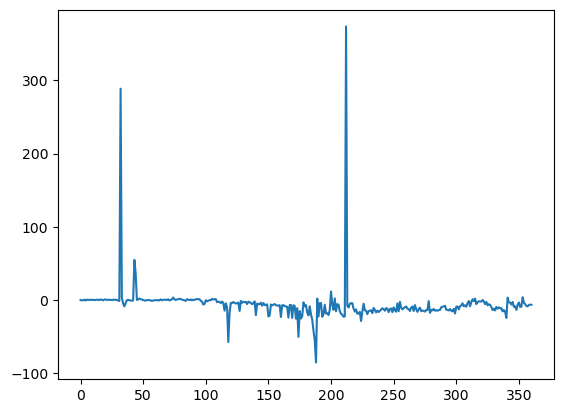

In [24]:
plt.plot(residuals_test)

In [31]:
mse = np.mean((b_test - b_pred)**2)
r2_score = 1 - (np.sum((b_test - b_pred)**2) / np.sum((b_test - np.mean(b_test))**2))
print('The mean square error on the test set is {}'.format(mse))
print('The R2 score on the test set is {}'.format(r2_score))


The mean square error on the test set is 780.8984793524866
The R2 score on the test set is -40.87585582907603


We can see from the figure of residuals that there are some outliers with large residual, which may lead to the large mse and r2.

## Question 3.4

In [39]:
# regularization parameter
lambda_ = 100

# change the A, b matrices to include the regularization term
num_features = A.shape[1]
A_reg = np.vstack([A, np.sqrt(lambda_) * np.eye(num_features)])
b_reg = np.concatenate([b, np.zeros(num_features)])

# Solve the regularized least squares problem
w_reg, residuals_reg, rank_reg, s_reg = np.linalg.lstsq(A_reg, b_reg, rcond=None)
print('The w are:', w_reg)
print('The residuals are:', residuals_reg)

# Calculate predictions
b_pred_reg = A_test @ w_reg
mse_reg = np.mean((b_pred_reg - b_test) ** 2)
r2_score_reg = 1 - (np.sum((b_test - b_pred_reg)**2) / np.sum((b_test - np.mean(b_test))**2))
print()
print('The mean square error after l2 regulaization on the test set is {}'.format(mse_reg))
print('The R2 score after l2 regulaization on the test set is {}'.format(r2_score_reg))


The w are: [-0.01238313  0.05780406 -0.00127775 ...  0.01590558 -0.03567897
  0.0131232 ]
The residuals are: [603.03064851]

The mean square error after l2 regulaization on the test set is 301.0548280940149
The R2 score after l2 regulaization on the test set is -15.144132574525923


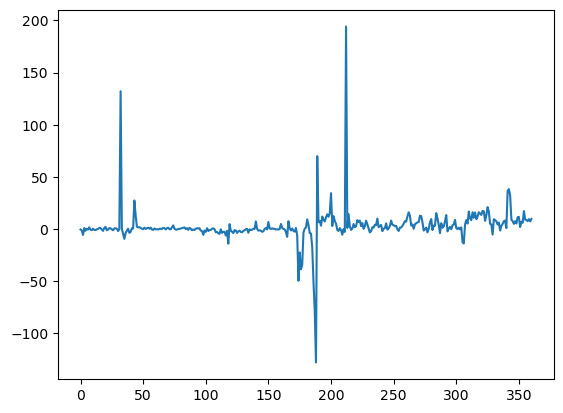

In [38]:
# calculate the residuals for the test set
residuals_test_reg = b_test - b_pred_reg
plt.plot(residuals_test_reg)

It is observed that the mse and r2 score decreased after l2 regularization, which indicates the improvement of prediction quality.

## Question 3.5

The gradient function will be computed as follows:

For the first term,
$\nabla_w (\frac{1}{2} \| Aw - b \|^2) = A^T (Aw - b) $

For the second term,
$ \nabla_w (\frac{\lambda}{2} \| w \|^2) = \lambda w $

Combining both, we have:
$ \nabla_w f_1(w) = A^T(Aw - b) + \lambda w $

The Hessian of the first term is $ A^T A $ and the Hessian of the second term is $ \lambda I $, they are positive semidefinite.

Therefore, the function $ f_1(w)$ is convex.

## Question 3.6

In [92]:
# calculate the Lipschitz coefficient

A1 = A.T @ A
lambda_ = 100
eigenvalues = np.linalg.eigvals(A1)
eigenvalues = np.sort(eigenvalues)
max_eigenvalue = eigenvalues[-1]
lip_coeff = 1 / (max_eigenvalue + lambda_)
print('The Lipschitz coefficient is {}'.format(lip_coeff))

The Lipschitz coefficient is (2.863161135661648e-07+0j)


We choose the step size that < 2* Lipschitz coefficient, which is 5*e-7.

In [90]:
# f1(w) = 1/2 (A w - b)^T (A w - b) + lambda/2 w^T w
# gradient descent to minimize f1

def compute_gradient(A, w, b, lambda_):
    return A.T @ (A @ w - b) + lambda_ * w

def gradient_descent(A, b, lambda_, learning_rate=5*1e-7, max_iter=100000, tolerance = 1):
    w = np.zeros(A.shape[1])
    gradient_norm = np.inf
    iter_num = 0
    
    while gradient_norm > tolerance and iter_num < max_iter:
        gradient = compute_gradient(A, w, b, lambda_)
        w = w - learning_rate * gradient
        gradient_norm = np.linalg.norm(gradient)
        iter_num += 1
    
    return w, iter_num

In [91]:
w_res, iter_num = gradient_descent(A, b, lambda_ = 100)
w_res, iter_num

(array([-0.01238055,  0.05775866, -0.00111775, ...,  0.01579912,
        -0.03571616,  0.0133528 ]),
 55858)

We can verify that if alpha is larger than $5*e^{-7}$, we will get RunTime Error, but if alpha is smaller, the model is converging too slowly.

With this choice of alpha, 55858 iterations are need such that the norm the gradient is smaller than 1.

In [93]:
# make predictions
b_pred= A_test @ w_res
mse = np.mean((b_test - b_pred)**2)
r2_score = 1 - (np.sum((b_test - b_pred)**2) / np.sum((b_test - np.mean(b_test))**2))
print('The mean square error on the test set is {}'.format(mse))
print('The R2 score on the test set is {}'.format(r2_score))

The mean square error on the test set is 302.0102332368782
The R2 score on the test set is -15.195366389264652


# Regularization for a sparse model

## Question 4.1

Here, $f_2 = \frac{1}{2}\|Aw-b\|^2$ and $g_2 = \lambda \|w\|_1$

The formula for $\text{prox}_{g2}(x)$ is $\text{prox}_{g2}(x) = \arg\min_y (g_2(y) + \frac{1}{2}\|x - y\|^2)$.

The gradient of $f_2$ is $\nabla f_2(\mathbf{w}) = A^T(A\mathbf{w} - \mathbf{b})$.

## Question 4.2

We have,
$$
{prox}_g(x_i) =p_i = \begin{cases}
= x_i + \lambda & \text{if } x_i < -\lambda \\
= 0 & \text{if } -\lambda \leq x_i - p_i \leq \lambda \\
= x_i - \lambda & \text{if } x_i > \lambda 
\end{cases}
$$

In [95]:
def prox_g(x, lambda_, alpha):
    result=[]
    lambda_reg=lambda_*alpha
    for i in x:
        if i>lambda_reg:
            result.append(i-lambda_reg)
        elif i<-lambda_reg:
            result.append(i+lambda_reg)
        else:
            result.append(0)
    return np.array(result)

In [96]:
def gradient_f2(A, b, w):
    return A.T @ (A @ w - b)

As we wish to force most of the nonzero values to be exactly 0, we set the number of nonzero value as a stopping criteria.

In [99]:
def proximal_gradient_descent(A, b, lambda_reg, alpha, tolerance=1, max_iterations=100000):
    w = np.ones(A.shape[1])
    gradient = gradient_f2(A, b, w)
    iter_num = 0
    gradient_norm = np.inf
    
    while gradient_norm > tolerance and np.sum(w!=0)>100 and iter_num < max_iterations:
        w = prox_g(w - alpha * gradient, lambda_reg, alpha)
        gradient = gradient_f2(A, b, w)
        gradient_norm = np.linalg.norm(gradient)
        iter_num += 1
    return w, iter_num

In [121]:
import  time
lambda_reg = 200 
alpha = 5*10**(-7)

start_tiem = time.time()
w, iter_num = proximal_gradient_descent(A, b, lambda_reg, alpha)
end_time = time.time()

print('The time for proximal gradient descent is {}'.format(end_time - start_tiem))
print('The w are:', w)
print('The number of iterations is {}'.format(iter_num))

The time for proximal gradient descent is 6.6064112186431885
The w are: [0. 0. 0. ... 0. 0. 0.]
The number of iterations is 11200


In [107]:
sum(w)

7.429807155774624

In [122]:
# make predictions
b_pred= A_test @ w
mse = np.mean((b_test - b_pred)**2)
r2_score = 1 - (np.sum((b_test - b_pred)**2) / np.sum((b_test - np.mean(b_test))**2))
print('The mean square error on the test set is {}'.format(mse))
print('The R2 score on the test set is {}'.format(r2_score))

The mean square error on the test set is 32.178118036241955
The R2 score on the test set is -0.7255587856362351


## Question 4.3

In [115]:
def cost_f2(A, b, w):
    pred_error = A @ w - b
    L =  np.sum(pred_error ** 2)/2
    return L

def line_search(A, b, w, grad, lambda_reg, alpha, beta=0.5):
    L1 = cost_f2(A, b, prox_g(w - alpha * grad, lambda_reg, alpha))
    L2 = cost_f2(A, b, w)
    while L1 > L2 + np.dot(grad, prox_g(w - alpha * grad, lambda_reg, alpha)-w) + 1/(2*alpha) * np.linalg.norm(prox_g(w - alpha * grad, lambda_reg, alpha)-w)**2:
        alpha *= beta
    return alpha

In [116]:
def proximal_gradient_descent_line_research(A, b, lambda_reg, alpha0, tolerance=1, max_iterations=100000):
    w = np.ones(A.shape[1])
    gradient = gradient_f2(A, b, w)
    iter_num = 0
    while np.linalg.norm(gradient) > tolerance and np.sum(w!=0)>100 and iter_num < max_iterations:
        alpha = line_search(A,b,w,gradient,lambda_reg,alpha0)
        w = prox_g(w - alpha * gradient,lambda_reg,alpha)
        gradient = gradient_f2(A, b, w)
        iter_num += 1
    return w, iter_num

In [120]:
lambda_reg = 200 
alpha = 5*10**(-7)

start_tiem = time.time()
w, iter_num = proximal_gradient_descent_line_research(A, b, lambda_reg, alpha)
end_time = time.time()

print('The time for proximal gradient descent is {}'.format(end_time - start_tiem))
print('The w are:', w)
print('The number of iterations is {}'.format(iter_num))

The time for proximal gradient descent is 17.654217004776
The w are: [0. 0. 0. ... 0. 0. 0.]
The number of iterations is 11202


Time longer? I got some doubts in this implementation. :(

## Question 6.1

We can see that the MSE and r2 score on test set is smaller when using the L1 regularization on this question.

The reason may be that this model is probably a sparse model, which fits well to the essence of L1 regularization by forcing zero weights.